**1**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer as timer
np.random.seed(1000)

In [17]:
def data():
    A = np.random.randn(1000, 10)
    x_bar = np.zeros(10)
    for i in range(10):
      if (i+1)%2 == 0:
        x_bar[i] = np.random.uniform(low = i+1, high = i+2)
      else:
        x_bar[i] = np.random.uniform(low = -(i+2), high = -(i+1) )
      x_bar = np.array(x_bar)
      x_bar = x_bar.reshape(10,1)
    epsilon = np.random.randn(1000, 1)
    y = np.add(np.dot(A, x_bar), epsilon)
    return A, x_bar, y

In [18]:
def evalf(l, A, x, y):
    assert type(l) is float
    assert type(x) is np.ndarray
    assert x.shape[0] == 10 and x.shape[1] == 1
    assert type(y) is np.ndarray and len(y) == A.shape[0]
    t = np.subtract(np.dot(A,x),y)
    f_val = np.multiply((l/2), np.dot(x.T,x)) + 0.5*np.linalg.norm(t,2)**2
    return f_val

In [19]:
def evalg(l, A, x, y):
    assert type(l) is float
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1
    assert type(y) is np.ndarray and len(y) == A.shape[0]
    t = np.dot(A,x) - y
    gradient = np.add(np.multiply(l,x), np.dot(A.T,t))
    return gradient

In [20]:
def evalh(l, A, x):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1
    hessian = np.multiply(l,np.identity(A.shape[1])) + np.matmul(A.T, A)
    return hessian

In [21]:
def compute_Dk_newton(l, A, x):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1
    p = np.linalg.inv(evalh(l, A, x))
    return p

In [7]:
#line search type
EXACT_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH = 2
CONSTANT_STEP_LENGTH = 3

In [22]:
def compute_steplength_backtracking(l, A, x, y, gradf, D_k, alpha_0, rho, gamma):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1
    assert type(y) is np.ndarray and len(y) == A.shape[0]
    assert type(gradf) is np.ndarray and len(gradf) == 10
    assert type(alpha_0) is float and alpha_0>=0.
    assert type(rho) is float and rho>=0.
    assert type(gamma) is float and gamma>=0.
    assert type(D_k) is np.ndarray and len(D_k) == 10
    alpha = alpha_0
    p_k = -np.dot(D_k,gradf)
    while evalf(l, A, np.add(x,np.multiply(alpha,p_k)),y) > np.multiply(gamma*alpha,np.dot(gradf.T,p_k)) + evalf(l, A,x,y):
        alpha = rho*alpha
    return alpha

In [25]:
def Newton_find_minimizer(l, start_x, A, y, tol, line_search_type, *args):
    assert type(l) is float
    assert type(start_x) is np.ndarray
    assert start_x.shape[0] == 10 and start_x.shape[1] == 1
    assert type(tol) is float and tol>=0
    x = start_x
    g_x = evalg(l, A, x, y)
    x_array = [x]
    f_array = [evalf(l, A, x,y)]
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            wrng = 'check!'
            raise ValueError(wrng)
        elif len(args)<3 :
            wrng = 'check!'
            raise ValueError(wrng)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    while (np.linalg.norm(g_x) > tol):
        d_k = compute_Dk_newton(l, A, x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking(l, A, x, y, g_x, d_k, alpha_start, rho, gamma)
        elif line_search_type == CONSTANT_STEP_LENGTH:
            step_length = 1.0
        else:
            raise ValueError('check!')

        x = np.subtract(x, np.multiply(step_length,np.dot(d_k, g_x)))
        k += 1
        g_x = evalg(l, A, x, y)
        x_array.append(x)
        f_array.append(evalf(l, A, x,y))
        if k % 4000 == 0:
            print('iter:',k, ' x:', x, ' f(x):', evalf(l, A, x, y), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
    return x_array, f_array, k

In [26]:
A, x_bar, y = data()

In [27]:
def BFGS_find_minimizer(l, start_x, A, y, tol, line_search_type, *args):
    assert type(l) is float
    assert type(start_x) is np.ndarray
    assert start_x.shape[0] == 10 and start_x.shape[1] == 1
    assert type(tol) is float and tol>=0
    x = start_x
    g_x = evalg(l, A, x, y)
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    B = np.identity(10)
    x_array = [x]
    f_array = [evalf(l, A, x,y)]

    while (np.linalg.norm(g_x) > tol):
        p = -np.dot(B, g_x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            d_k = B
            step_length = compute_steplength_backtracking(l, A, x, y, g_x, d_k, alpha_start, rho, gamma)
        elif line_search_type == CONSTANT_STEP_LENGTH:
            step_length = 1.0
        else:
            raise ValueError('Line search type unknown. Please check!')
        x_next = np.add(x, np.multiply(step_length,p))
        s_k = x_next - x
        y_k = evalg(l, A, x_next,y) - g_x
        mu_k = 1.0/np.dot(y_k.T, s_k)
        temp = (np.identity(10) - np.multiply(mu_k,np.outer(y_k, s_k.T)))
        B = np.dot(temp.T, np.dot(B, temp)) + np.multiply(mu_k, np.outer(s_k, s_k.T))
        k += 1
        x = x_next
        g_x = evalg(l, A, x, y)
        x_array.append(x)
        f_array.append(evalf(l, A, x, y))
        if k % 4000 == 0:
            print('iter:',k, ' x:', x, ' f(x):', evalf(l, A, x, y), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
    return x_array, f_array, k

**1)**
In the previous exercise, the Hessian matrix was $\mathbf{A^TA}$, but by adding a regularizer term, it becomes $\mathbf{A^TA} + \lambda\mathbf{I}$. One cannot guarantee the invertibility of the matrix $\mathbf{A^TA}$, so it is possible that the inverse of the Hessian matrix doesn't exist for the previous exercise. However, the matrix $\mathbf{A^TA} + \lambda\mathbf{I}$ is always invertible because $\mathbf{A^TA}$ is symmetric, and by adding positive diagonal elements to a symmetric matrix, we ensure the positivity of eigenvalues. Therefore, for $\lambda > 0$, the inverse of the Hessian matrix always exists for the regularized function in this exercise.


In [39]:
t1= 1e-5
alpha_0 = 0.99
rho = 0.5
gamma = 0.5
l = [0.001, 0.01, 0.1, 1.0]

**4)**

In [40]:
x_0 = []
for i in range(10):
  x_0.append([0])
x_0 = np.array(x_0)
x_array_newton2 = [[] for _ in range(len(l))]
iters_newton2  = [0 for _ in range(len(l))]
f_array_newton2 = [[] for _ in range(len(l))]
times_newton2 = [0 for _ in range(len(l))]
for i in range(len(l)):
    start_time = timer()
    x_array_newton2[i], f_array_newton2[i], iters_newton2[i] = Newton_find_minimizer(l[i], x_0, A, y, t1, BACKTRACKING_LINE_SEARCH, alpha_0, rho, gamma)
    end_time = timer()
    times_newton2[i] = end_time - start_time
    print(f'For lambda = {l[i]}:')
    print(f"Time taken to find optimal x* by Newton's method for lambda = {l[i]}: {times_newton2[i]}\nIterations: {iters_newton2[i]}")
    start_time = timer()

print()
print(f'Actual x_bar: {x_bar.reshape(1,-1)}')
print('')
x_opt_newton2 = [x_array_newton2[i][-1] for i in range(len(l))]

For lambda = 0.001:
Time taken to find optimal x* by Newton's method for lambda = 0.001: 0.008748110999931669
Iterations: 6
For lambda = 0.01:
Time taken to find optimal x* by Newton's method for lambda = 0.01: 0.006101042999944184
Iterations: 5
For lambda = 0.1:
Time taken to find optimal x* by Newton's method for lambda = 0.1: 0.00446447000012995
Iterations: 5
For lambda = 1.0:
Time taken to find optimal x* by Newton's method for lambda = 1.0: 0.002756560999841895
Iterations: 5

Actual x_bar: [[-1.46183131  2.5104537  -3.08653538  4.91743968 -5.23406969  6.51185984
  -7.94985013  8.41440356 -9.61122766 10.97100909]]



In [41]:
x_0 = []
for i in range(10):
  x_0.append([0])
x_0 = np.array(x_0)
x_array_bfgs2 = [[] for _ in range(len(l))]
iters_bfgs2  = [0 for _ in range(len(l))]
f_array_bfgs2 = [[] for _ in range(len(l))]
times_bfgs2 = [0 for _ in range(len(l))]
for i in range(len(l)):
    start_time = timer()
    print(f'For lambda = {l[i]}:')
    x_array_bfgs2[i], f_array_bfgs2[i], iters_bfgs2[i]  = BFGS_find_minimizer(l[i], x_0, A, y, t1, BACKTRACKING_LINE_SEARCH, alpha_0, rho, gamma)
    end_time = timer()
    times_bfgs2[i] = end_time - start_time
    print(f"Time taken to find optimal x* by BFGS method for lambda = {l[i]}: {times_bfgs2[i]}\nIterations: {iters_bfgs2[i]}")
    print('')
print()
print(f'Actual x_bar: {x_bar.reshape(1,-1)}')
print('')
x_opt_bfgs2 = [x_array_bfgs2[i][-1] for i in range(len(l))]

For lambda = 0.001:
Time taken to find optimal x* by BFGS method for lambda = 0.001: 0.056801677999828826
Iterations: 16

For lambda = 0.01:
Time taken to find optimal x* by BFGS method for lambda = 0.01: 0.03449943199984773
Iterations: 16

For lambda = 0.1:
Time taken to find optimal x* by BFGS method for lambda = 0.1: 0.040726502999859804
Iterations: 16

For lambda = 1.0:
Time taken to find optimal x* by BFGS method for lambda = 1.0: 0.03936484100040616
Iterations: 16


Actual x_bar: [[-1.46183131  2.5104537  -3.08653538  4.91743968 -5.23406969  6.51185984
  -7.94985013  8.41440356 -9.61122766 10.97100909]]



 **Graph of the values $log(||x^k - x^*||_2$)**

<ipython-input-43-121e534f2934>:5: RuntimeWarning: divide by zero encountered in log
  plot_x2[i].append(np.log(np.linalg.norm(x_array_newton2[i][j] - x_opt_newton2[i])))


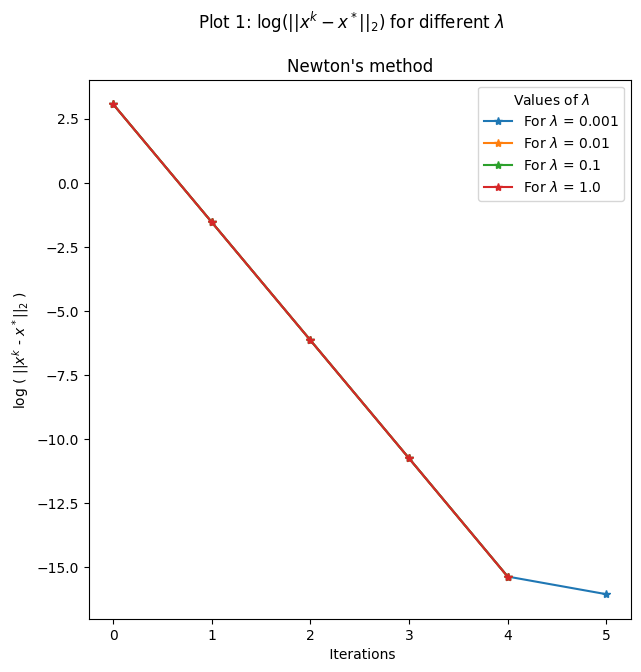

In [43]:
x_opt_newton2 = [x_array_newton2[i][-1] for i in range(len(l))]
plot_x2 = [[] for _ in range(len(l))]
for i in range(len(l)):
    for j in range(len(x_array_newton2[i])):
        plot_x2[i].append(np.log(np.linalg.norm(x_array_newton2[i][j] - x_opt_newton2[i])))

fig, ax = plt.subplots(1, 1, figsize = (7,7))
fig.suptitle("Plot 1: log($||x^k - x^*||_2$) for different $\lambda$")
for i in range(len(l)):
    ax.plot(np.arange(len(x_array_newton2[i])), plot_x2[i], '*-', label = f"For $\lambda$ = {l[i]}")
ax.set_title("Newton's method")
ax.set_xlabel(" Iterations")
ax.set_ylabel(r"log ( ||$x^k$ - $x^*||_2$ )")
ax.legend(title = 'Values of $\lambda$')

**Graph of the values $log(||f(x^k) - f(x^*)||_2)$**

In [44]:
f_opt_newton2 = [f_array_newton2[i][-1] for i in range(len(l))]
plot_fx2 = [[] for _ in range(len(l))]
for i in range(len(l)):
    for j in range(len(f_array_newton2[i])):
        plot_fx2[i].append(np.log(np.linalg.norm(f_array_newton2[i][j] - f_opt_newton2[i])))

fig, ax = plt.subplots(1,1, figsize = (7,7))
fig.suptitle("Plot 2: log( $|f(x^k) - f(x^*)|$ ) for different $\lambda$")
for i in range(len(l)):
    ax.plot(np.arange(len(f_array_newton2[i])), plot_fx2[i], '*-', label = f"For $\lambda$ = {l[i]}")
ax.set_title("Newton's method")
ax.set_xlabel(" Iterations")
ax.set_ylabel(r"log ( |$f(x^k)$ - $f(x*)$| )")
ax.legend(title = 'Values of $\lambda$')

<ipython-input-44-f8e4ed014a4a>:5: RuntimeWarning: divide by zero encountered in log
  plot_fx2[i].append(np.log(np.linalg.norm(f_array_newton2[i][j] - f_opt_newton2[i])))




**4)**
$x^*$ and $\bar{x}$ are nearly equal within the given precision of error. The optimal solution $x^*$ remains the same for both Newton's and BFGS methods for all the given starting points. The plot between $\log(\|x^k - x^*\|)$ and Iterations for Newton's method and BFGS method exhibits Q-linear behavior for all given starting points. However, the difference is that it is Q-linear for Newton's method from the start, whereas it becomes Q-linear for BFGS after a few iterations.

Similarly, the plot between $\log(|f(x^k) - f(x^*)|)$ and Iterations for Newton's method and BFGS method mirrors the plot between $\log(\|x^k - x^*\|)$ and Iterations, albeit with different scaling on both axes, indicating similar behavior. Newton's method demonstrates faster convergence compared to the BFGS method because it exhibits Q-linear behavior from the beginning, whereas BFGS achieves Q-linear convergence after a few iterations.


**5)**

<ipython-input-48-a289a8ffb39b>:5: RuntimeWarning: divide by zero encountered in log
  plot_x_bfgs[i].append(np.log(np.linalg.norm(x_array_bfgs2[i][j] - x_opt_bfgs[i])))


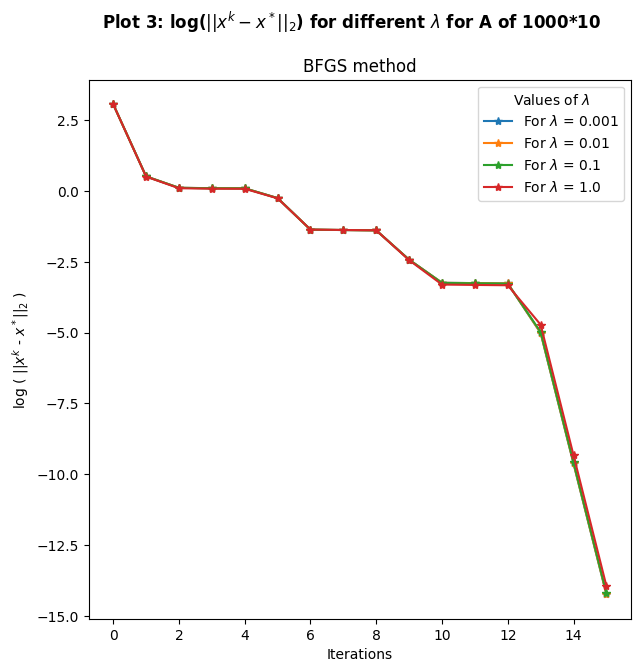

In [48]:
x_opt_bfgs = [x_array_bfgs2[i][-1] for i in range(len(l))]
plot_x_bfgs = [[] for _ in range(len(l))]
for i in range(len(l)):
    for j in range(len(x_array_bfgs2[i])):
        plot_x_bfgs[i].append(np.log(np.linalg.norm(x_array_bfgs2[i][j] - x_opt_bfgs[i])))

fig, ax = plt.subplots(1,1, figsize = (7,7))
fig.suptitle("Plot 3: log($||x^k - x^*||_2$) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(l)):
    ax.plot(np.arange(len(x_array_bfgs2[i])), plot_x_bfgs[i], '*-', label = f"For $\lambda$ = {l[i]}")
ax.set_title("BFGS method")
ax.set_xlabel("Iterations")
ax.set_ylabel(r"log ( ||$x^k$ - $x^*||_2$ )")
ax.legend(title = 'Values of $\lambda$')

<ipython-input-49-7852371d4e0a>:5: RuntimeWarning: divide by zero encountered in log
  plot_fx_bfgs[i].append(np.log(np.linalg.norm(f_array_bfgs2[i][j] - f_opt_bfgs[i])))


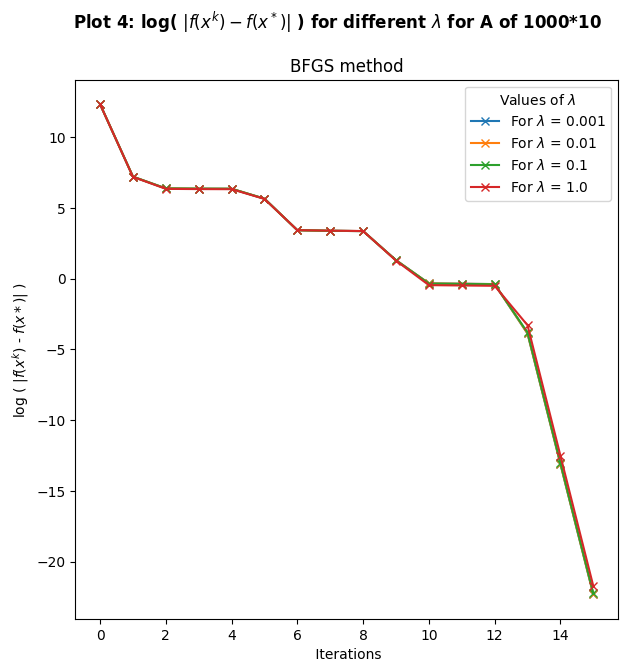

In [49]:
f_opt_bfgs = [f_array_bfgs2[i][-1] for i in range(len(l))]
plot_fx_bfgs = [[] for _ in range(len(l))]
for i in range(len(l)):
    for j in range(len(f_array_bfgs2[i])):
        plot_fx_bfgs[i].append(np.log(np.linalg.norm(f_array_bfgs2[i][j] - f_opt_bfgs[i])))
fig, ax = plt.subplots(1, 1, figsize = (7,7))
fig.suptitle("Plot 4: log( $|f(x^k) - f(x^*)|$ ) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(l)):
    ax.plot(np.arange(len(f_array_bfgs2[i])), plot_fx_bfgs[i], 'x-', label = f"For $\lambda$ = {l[i]}")
ax.set_title("BFGS method")
ax.set_xlabel(" Iterations")
ax.set_ylabel(r"log ( |$f(x^k)$ - $f(x*)$| )")
ax.legend(title = 'Values of $\lambda$')

"$x^∗$" and "$x¯$" are nearly identical within the given precision of error. The optimal solution "$x^∗$" remains consistent for both Newton's and BFGS methods across all provided starting points. The plot depicting the relationship between $\log(\|x_k - x^*\|)$ and Iterations for Newton's method and BFGS method exhibits Q-linear behavior for all given starting points. However, the distinction lies in the fact that it is Q-linear for Newton's method from the outset, whereas it becomes Q-linear for BFGS after several iterations.

Similarly, the plot between $\log(|f(x_k) - f(x^*)|)$ and Iterations for Newton's method and BFGS method mirrors the plot between $\log(\|x_k - x^*\|)$ and Iterations, albeit with different scaling on both axes, indicating similar behavior. Newton's method demonstrates faster convergence compared to BFGS method because it exhibits Q-linear behavior from the beginning, whereas BFGS achieves Q-linear convergence after a few iterations.


**6)**

For different values of $\lambda$, the resulting optimal solution $x^*$, intermediate solution $\bar{x}$, corresponding values of the objective function $f(x^*)$ and $f(\bar{x})$, along with the computational time required are as follows:

 **1)**lambda = 0.001, $x^*$ = (-3.8946358219518213, 6.158177582958033), $\bar{x}$ = (-3.8864520683267783, 6.149324214707549), $f(x^*)$ = 4754.37010610238, $f(\bar{x})$ = 4755.077913531231, Time = 0.010154251000130898.

 2)lambda = 0.1, $x^*$ = (-3.8945965053733778, 6.158114664714515), $\bar{x}$ = (-3.8864520683267783, 6.149324214707549), $f(x^*)$ = 4756.998100640705, $f(\bar{x})$ = 4757.697389081092, Time = 0.005226085000685998.

  3)lambda = 1.0, $x^*$ = (-3.8942391185106873, 6.157542739927886), $\bar{x}$ = (-3.8864520683267783, 6.149324214707549), $f(x^*)$ = 4780.886505582736, $f(\bar{x})$ = 4781.510803170738, Time = 0.004265139001290663.
  
  4)lambda = 10.0, $x^*$ = (-3.8906688517338135, 6.151829326691304), $\bar{x}$ = (-3.8864520683267783, 6.149324214707549), $f(x^*)$ = 5019.527566433189$, $f(\bar{x})$ = 5019.644944067193, Time = 0.0037762970005132956.

5) lambda = 100.0, $x^*$ = (-3.855322930258129, 6.0952730071477506), $\bar{x}$ = (-3.8864520683267783, 6.149324214707549), $f(x^*)$ = 7381.886450401795, $f(\bar{x})$ = 7400.986353031748, Time = 0.003730933000042569.


These results demonstrate the impact of the regularization parameter $\lambda$ on the optimization process.
